# Differential spectrum balance - Dev
This notebook was used to formulate and test code for DSB fitting function.

## Preface
Definitions and all, cannot get anywhere without these.

In [1]:
# Main imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import scipy as sc

Matplotlib is building the font cache; this may take a moment.


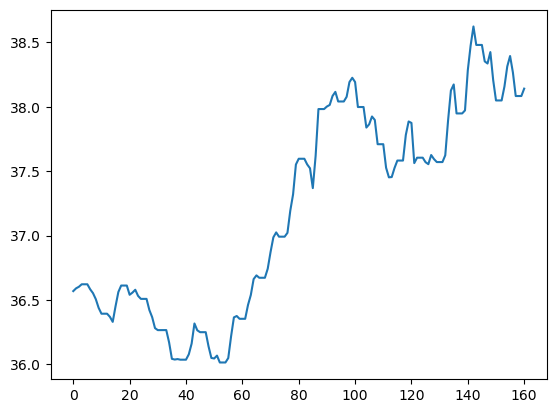

In [22]:
# Import data
raw_data = pd.read_excel("data/usd_2023-2024_1.xlsx", "USD")
usd_data = np.array(raw_data.iloc[0:161, 6].values)
plt.plot(usd_data)
plt.show()

In [23]:
# String define model
raw_model = "a0 + a1*t + a2*sin(a3*t) + a4*cos(a5*t)"
model = sp.parse_expr(raw_model)

# String define poly
raw_poly = "c0 + c1*t + c2*t**2 + c3*t**3 + c4*t**4 + c5*t**5"
poly = sp.parse_expr(raw_poly)

# Define main var
t = sp.var("t")

display(model)
display(poly)

a0 + a1*t + a2*sin(a3*t) + a4*cos(a5*t)

c0 + c1*t + c2*t**2 + c3*t**3 + c4*t**4 + c5*t**5

## Differential spectrum balancing
Do the thing, also includes LMS for polynomial side of things.

In [24]:
# Do the LMS thing
poly_vals = np.polyfit(np.arange(0, usd_data.size), usd_data, 5)
poly_vals

array([ 9.72669120e-10, -3.52193089e-07,  4.05777958e-05, -1.36826602e-03,
       -2.33959937e-03,  3.66670632e+01])

In [25]:
# Do the DSB thing
series = sp.series(model, t).removeO()
poly_s = sp.series(poly, t).removeO()

display(series)
display(poly_s)

a0 + a2*a3**5*t**5/120 - a2*a3**3*t**3/6 + a4*a5**4*t**4/24 - a4*a5**2*t**2/2 + a4 + t*(a1 + a2*a3)

c0 + c1*t + c2*t**2 + c3*t**3 + c4*t**4 + c5*t**5

In [26]:
model_coeffs = sp.poly(series, t).coeffs()
poly_coeffs = sp.poly(poly_s, t).coeffs()
for i, c in enumerate(model_coeffs):
    display(model_coeffs[i], poly_coeffs[i])

a2*a3**5/120

c5

a4*a5**4/24

c4

-a2*a3**3/6

c3

-a4*a5**2/2

c2

a1 + a2*a3

c1

a0 + a4

c0

In [27]:
model_a = model.free_symbols
model_a.remove(t)
poly_c = poly.free_symbols
poly_c.remove(t)

display(model_a)
display(poly_c)

{a0, a1, a2, a3, a4, a5}

{c0, c1, c2, c3, c4, c5}

In [28]:
model_plain = model.copy()
for a in model_a:
    model_plain = model_plain.subs(a, 1)

if model_plain.has(1):
    model_plain = model_plain - 1

model_plain

t + sin(t) + cos(t)

In [29]:
series_plain = sp.series(model_plain, t).removeO()
series_plain

t**5/120 + t**4/24 - t**3/6 - t**2/2 + 2*t + 1

In [30]:
model_plain_coeffs = sp.poly(series_plain, t).coeffs()
model_plain_coeffs

[1/120, 1/24, -1/6, -1/2, 2, 1]

In [31]:
discretes = []
for i in range(len(model_coeffs)):
    discretes.append(model_coeffs[i] / model_plain_coeffs[i])

for d in discretes:
    display(d)

a2*a3**5

a4*a5**4

a2*a3**3

a4*a5**2

a1/2 + a2*a3/2

a0 + a4

In [32]:
balance = []
for i, d in enumerate(discretes):
    balance.append(sp.Eq(d, poly_coeffs[i]))

for d in balance:
    display(d)

Eq(a2*a3**5, c5)

Eq(a4*a5**4, c4)

Eq(a2*a3**3, c3)

Eq(a4*a5**2, c2)

Eq(a1/2 + a2*a3/2, c1)

Eq(a0 + a4, c0)

In [33]:
model_a_list = sorted(model_a, key=lambda s: s.name)
solution = sp.nonlinsolve(balance, model_a_list)
if len(solution) > 1:
    solution = list(solution)[0]
display(model_a_list, solution)

[a0, a1, a2, a3, a4, a5]

((c0*c4 - c2**2)/c4, (2*c1*c5 - c3**2)/c5, c3**3*sqrt(c5/c3)/c5**2, sqrt(c5/c3), c2**2/c4, sqrt(c4/c2))

## Substitution
General solution that we found is well and good, but we need to make it more specific to be more useful.

In [34]:
# Substitute original model
for i, a in enumerate(model_a_list):
    model = model.subs(a, solution[i])
model.simplify()

c0 + 2*c1*t + c2**2*cos(t*sqrt(c4/c2))/c4 - c2**2/c4 + c3**3*sqrt(c5/c3)*sin(t*sqrt(c5/c3))/c5**2 - c3**2*t/c5

In [35]:
# Substitute with calculated poly values
for i, c in enumerate(poly_coeffs):
    model = model.subs(c, poly_vals[i])
model

-1.69750307923766*t + 345.758956720365*sin(0.00489596537585437*t) - 5.3156974264557*cos(0.0160437225983562*t) + 41.9827606615224

In [36]:
for i, c in enumerate(poly_coeffs):
    solution = solution.subs(c, poly_vals[i])
solution

(41.9827606615224, -1.69750307923766, 345.758956720365, 0.00489596537585437, -5.3156974264557, 0.0160437225983562)

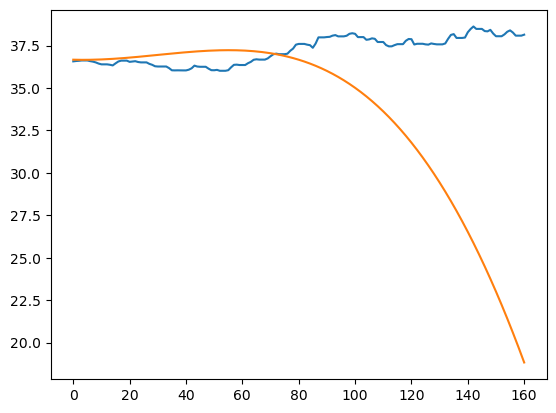

In [37]:
model_y = np.ndarray(len(usd_data))
for i in np.arange(model_y.size):
    model_y[i] = model.subs(t, i)

plt.plot(usd_data)
plt.plot(model_y)
plt.show()

## Numeric
As one can see, DSB on itself cannot produce any normal results, so we need to give it a friend in the form of cure fit. \
_It's so curvy..._

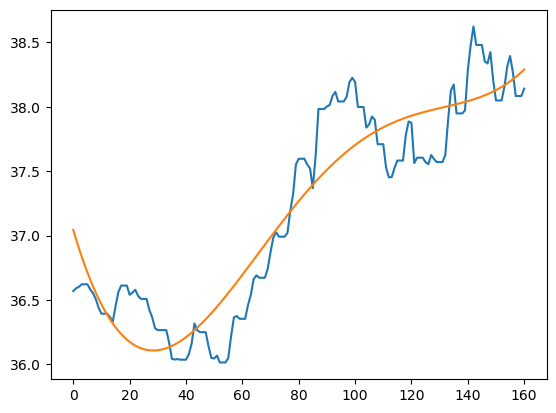

In [38]:
# Do the numeric thing
model_r = sp.parse_expr(raw_model)
model_al = model_a_list.copy()
model_al.insert(0, t)
model_l = sp.lambdify(model_al, model_r)

sol = np.array(solution).astype(np.float64)

coeffs = sc.optimize.curve_fit(
    model_l, np.arange(usd_data.size), usd_data, p0=sol, maxfev=100000
)

model_yr = np.ndarray(len(usd_data))
for i in np.arange(usd_data.size):
    model_yr[i] = model_l(i, *coeffs[0])

plt.plot(usd_data)
plt.plot(model_yr)
plt.show()